In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, activations, losses, optimizers, metrics
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [34]:
train_df = pd.read_csv("dataset_train.csv")
val_df = pd.read_csv("dataset_val.csv")

In [35]:
train_df

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,state
0,-0.774121,-9.433371,1.784629,0.012470,-0.020279,0.001386,STAND
1,-0.759082,-9.441336,1.766234,0.001488,-0.017445,-0.002156,STAND
2,-0.726570,-9.446578,1.737082,-0.009375,-0.016630,-0.005044,STAND
3,-0.691625,-9.455801,1.717754,-0.010948,-0.015826,-0.009066,STAND
4,-0.647156,-9.461336,1.690160,-0.010913,-0.018142,-0.011370,STAND
...,...,...,...,...,...,...,...
17115,-0.369055,-9.602301,1.091332,0.004793,0.006843,0.002358,STAND
17116,-0.379781,-9.598336,1.106293,0.004885,0.004316,0.003684,STAND
17117,-0.388988,-9.594660,1.121250,0.006213,0.007398,0.003539,STAND
17118,-0.396617,-9.593133,1.142656,0.007079,0.007009,0.003251,STAND


In [36]:
def encode(df):
    df.state = df.state.astype('category')
    df.state = df.state.cat.codes
    return df


train_df = encode(train_df)
val_df = encode(val_df)

In [37]:
train_df

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,state
0,-0.774121,-9.433371,1.784629,0.012470,-0.020279,0.001386,8
1,-0.759082,-9.441336,1.766234,0.001488,-0.017445,-0.002156,8
2,-0.726570,-9.446578,1.737082,-0.009375,-0.016630,-0.005044,8
3,-0.691625,-9.455801,1.717754,-0.010948,-0.015826,-0.009066,8
4,-0.647156,-9.461336,1.690160,-0.010913,-0.018142,-0.011370,8
...,...,...,...,...,...,...,...
17115,-0.369055,-9.602301,1.091332,0.004793,0.006843,0.002358,8
17116,-0.379781,-9.598336,1.106293,0.004885,0.004316,0.003684,8
17117,-0.388988,-9.594660,1.121250,0.006213,0.007398,0.003539,8
17118,-0.396617,-9.593133,1.142656,0.007079,0.007009,0.003251,8


Text(0.5, 1.0, 'Gyroscope Z')

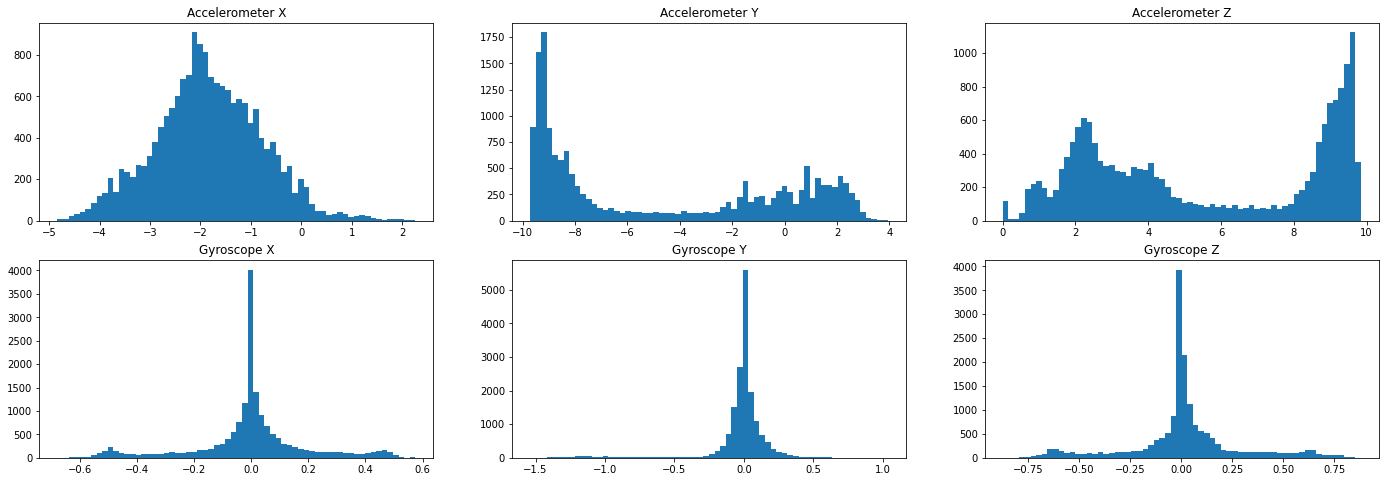

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(8 * 3, 8))
ax[0, 0].hist(train_df.accelerometer_x, bins=64);
ax[0, 0].set_title("Accelerometer X")
ax[0, 1].hist(train_df.accelerometer_y, bins=64);
ax[0, 1].set_title("Accelerometer Y")
ax[0, 2].hist(train_df.accelerometer_z, bins=64);
ax[0, 2].set_title("Accelerometer Z")

ax[1, 0].hist(train_df.gyroscope_x, bins=64);
ax[1, 0].set_title("Gyroscope X")
ax[1, 1].hist(train_df.gyroscope_y, bins=64);
ax[1, 1].set_title("Gyroscope Y")
ax[1, 2].hist(train_df.gyroscope_z, bins=64);
ax[1, 2].set_title("Gyroscope Z")

In [39]:
def normalize(column):
    return (column - column.min()) / ((column.max() - column.min()) / 2) - 1


In [40]:
def normalize_columns(df):
    columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']
    for column in columns:
        df[column] = normalize(df[column])
    return df


train_df = normalize_columns(train_df)
val_df = normalize_columns(val_df)


Text(0.5, 1.0, 'Gyroscope Z')

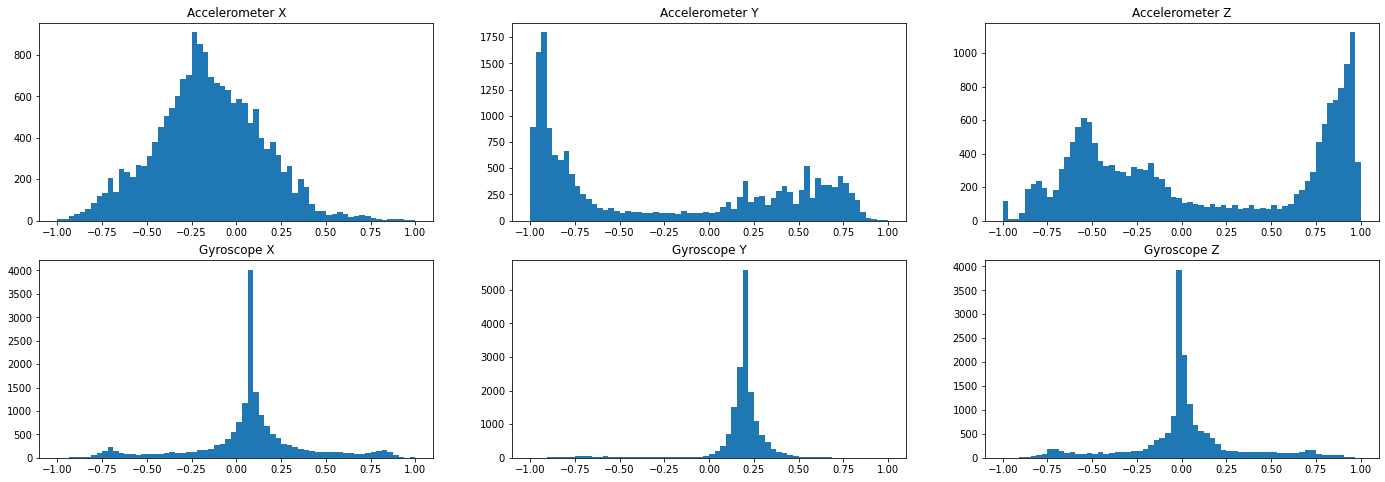

In [41]:
_, ax = plt.subplots(2, 3, figsize=(8 * 3, 8))
ax[0, 0].hist(train_df.accelerometer_x, bins=64)
ax[0, 0].set_title("Accelerometer X")
ax[0, 1].hist(train_df.accelerometer_y, bins=64)
ax[0, 1].set_title("Accelerometer Y")
ax[0, 2].hist(train_df.accelerometer_z, bins=64)
ax[0, 2].set_title("Accelerometer Z")

ax[1, 0].hist(train_df.gyroscope_x, bins=64)
ax[1, 0].set_title("Gyroscope X")
ax[1, 1].hist(train_df.gyroscope_y, bins=64)
ax[1, 1].set_title("Gyroscope Y")
ax[1, 2].hist(train_df.gyroscope_z, bins=64)
ax[1, 2].set_title("Gyroscope Z")

In [102]:
def create_window(df: pd.DataFrame, window=64, step=32):
    window_x = []
    window_y = []

    for i in range(0, len(df) - window, step):
        window_x.append(df.iloc[i:i + window])
        window_y.append(df.iloc[i + window]['state'])

    window_x = np.array(window_x)
    window_y = np.array(window_y)

    return window_x, window_y


train_x, train_y = create_window(train_df)
val_x, val_y = create_window(val_df)

In [105]:
_x = 128

fig = go.Figure()
fig.add_trace(go.Scatter(y=train_x[_x, :, 3]))
fig.add_trace(go.Scatter(y=train_x[_x, :, 4]))
fig.add_trace(go.Scatter(y=train_x[_x, :, 5]))


In [62]:
def shuffle_window(x, y):
    ind = np.arange(x.shape[0])
    np.random.shuffle(ind)
    return x[ind], y[ind]


train_x, train_y = shuffle_window(train_x, train_y)
val_x, val_y = shuffle_window(val_x, val_y)

In [63]:
def plot_history(title: str, history):
    _, ax = plt.subplots(1, 2, figsize=(6 * 3, 6))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.title(title)
    plt.legend()


# Hyper parameters

In [64]:
N_EPOCHS = 64
BATCH_SIZE = 128

Epoch 1/64
5/5 [==============================] - 2s 149ms/step - loss: 2.7306 - sparse_categorical_accuracy: 0.1257 - val_loss: 2.6371 - val_sparse_categorical_accuracy: 0.2424
Epoch 2/64
5/5 [==============================] - 0s 78ms/step - loss: 2.5813 - sparse_categorical_accuracy: 0.2664 - val_loss: 2.4720 - val_sparse_categorical_accuracy: 0.2121
Epoch 3/64
5/5 [==============================] - 0s 78ms/step - loss: 2.3615 - sparse_categorical_accuracy: 0.2739 - val_loss: 2.2853 - val_sparse_categorical_accuracy: 0.2348
Epoch 4/64
5/5 [==============================] - 0s 79ms/step - loss: 2.1974 - sparse_categorical_accuracy: 0.2683 - val_loss: 2.1708 - val_sparse_categorical_accuracy: 0.2348
Epoch 5/64
5/5 [==============================] - 0s 79ms/step - loss: 2.0812 - sparse_categorical_accuracy: 0.3058 - val_loss: 2.0892 - val_sparse_categorical_accuracy: 0.2576
Epoch 6/64
5/5 [==============================] - 0s 80ms/step - loss: 2.0092 - sparse_categorical_accuracy: 0.364

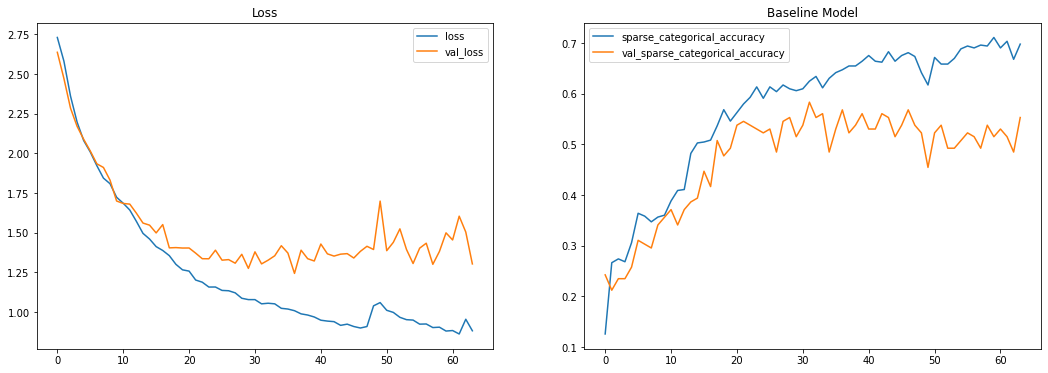

In [65]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=train_x.shape[0] // BATCH_SIZE,
    decay_rate=0.98,
    staircase=True)


def get_baseline_model(input_shape=(64, 6), n_output=16):
    model = models.Sequential()
    model.add(layers.LSTM(units=128, input_shape=input_shape))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate_schedule),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


baseline_model = get_baseline_model()
baseline_model_history = baseline_model.fit(
    x=train_x, y=train_y,
    shuffle=True, validation_data=(val_x, val_y),
    epochs=N_EPOCHS, batch_size=BATCH_SIZE)
plot_history('Baseline Model', baseline_model_history)

Epoch 1/64
5/5 [==============================] - 3s 248ms/step - loss: 2.7062 - sparse_categorical_accuracy: 0.1520 - val_loss: 2.5668 - val_sparse_categorical_accuracy: 0.2121
Epoch 2/64
5/5 [==============================] - 1s 126ms/step - loss: 2.4668 - sparse_categorical_accuracy: 0.2664 - val_loss: 2.2829 - val_sparse_categorical_accuracy: 0.2197
Epoch 3/64
5/5 [==============================] - 1s 129ms/step - loss: 2.1763 - sparse_categorical_accuracy: 0.2570 - val_loss: 2.1356 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/64
5/5 [==============================] - 1s 131ms/step - loss: 2.0453 - sparse_categorical_accuracy: 0.2702 - val_loss: 2.0285 - val_sparse_categorical_accuracy: 0.2121
Epoch 5/64
5/5 [==============================] - 1s 129ms/step - loss: 1.9770 - sparse_categorical_accuracy: 0.2871 - val_loss: 1.9968 - val_sparse_categorical_accuracy: 0.2652
Epoch 6/64
5/5 [==============================] - 1s 128ms/step - loss: 1.9012 - sparse_categorical_accuracy: 

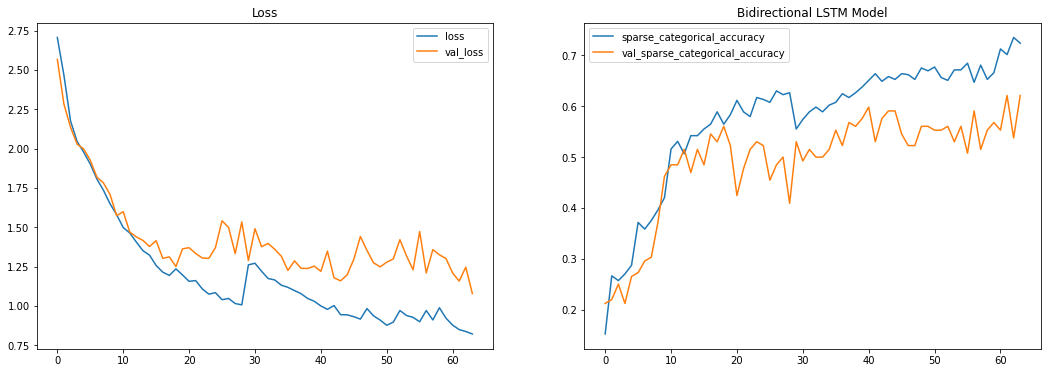

In [66]:
def get_bidirectional_lstm_model(input_shape=(64, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units=128, input_shape=input_shape)))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


bidirectional_lstm_model = get_bidirectional_lstm_model()
bidirectional_lstm_model_history = bidirectional_lstm_model.fit(
    x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
plot_history('Bidirectional LSTM Model', bidirectional_lstm_model_history)

Epoch 1/32
17/17 [==============================] - 6s 123ms/step - loss: 2.4741 - sparse_categorical_accuracy: 0.2176 - val_loss: 2.2091 - val_sparse_categorical_accuracy: 0.2424
Epoch 2/32
17/17 [==============================] - 1s 75ms/step - loss: 2.0901 - sparse_categorical_accuracy: 0.3077 - val_loss: 1.9638 - val_sparse_categorical_accuracy: 0.2879
Epoch 3/32
17/17 [==============================] - 1s 72ms/step - loss: 1.8541 - sparse_categorical_accuracy: 0.3677 - val_loss: 1.7715 - val_sparse_categorical_accuracy: 0.3258
Epoch 4/32
17/17 [==============================] - 1s 69ms/step - loss: 1.6913 - sparse_categorical_accuracy: 0.4184 - val_loss: 1.7883 - val_sparse_categorical_accuracy: 0.3561
Epoch 5/32
17/17 [==============================] - 1s 67ms/step - loss: 1.7958 - sparse_categorical_accuracy: 0.4034 - val_loss: 2.0041 - val_sparse_categorical_accuracy: 0.2727
Epoch 6/32
17/17 [==============================] - 1s 69ms/step - loss: 1.7877 - sparse_categorical_acc

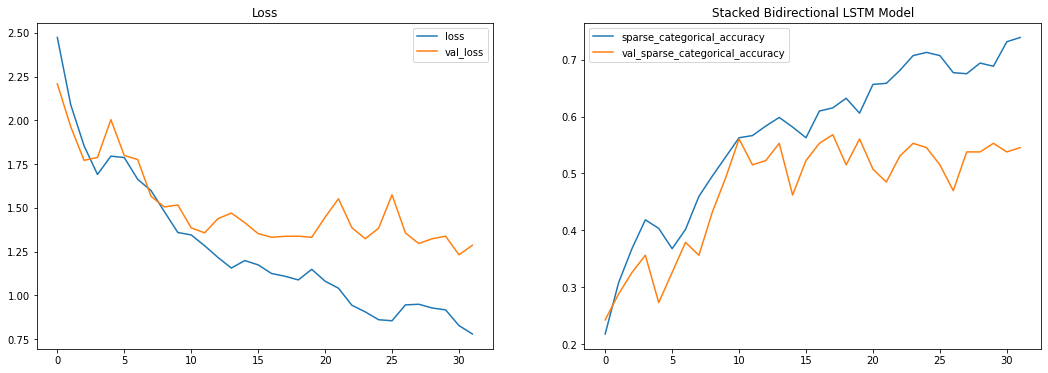

In [67]:
def get_stacked_bidirectional_lstm_model(input_shape=(64, 7), n_output=16):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True, input_shape=input_shape)))
    model.add(layers.Bidirectional(layers.LSTM(units=32)))
    model.add(layers.Dense(units=n_output, activation=activations.softmax))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=losses.sparse_categorical_crossentropy,
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


stacked_bidirectional_lstm_model = get_stacked_bidirectional_lstm_model()
stacked_bidirectional_lstm_model_history = stacked_bidirectional_lstm_model.fit(x=train_x, y=train_y,
                                                                                validation_data=(val_x, val_y),
                                                                                epochs=32)
plot_history('Stacked Bidirectional LSTM Model', stacked_bidirectional_lstm_model_history)